# Getting Started with Jaxloop

The objective of this starter notebook is to provide a quick introduction to the bare-minimum usage of Jaxloop (go/jaxloop).

We'll go over the process of training a simple ANN model using known data, generated on the fly.

## Dataset & Modeling

First, let's create a sample dataset based on `y = sin(x)` (ground truth).

Our training split will cover a [-4, 4] range, with 2666 (evenly-spaced) points.  To differentiate the test split, it will have 1000 points in [-5, 5].

We also have a utility function to shuffle batches of data during training.

In [ ]:
import jax.numpy as jnp

def datasets():
  """Generate some data examples (truth: y = sin(x))."""

  train_x = jnp.arange(-4, 4, 0.003, dtype=jnp.float32)
  test_x = jnp.arange(-5, 5, 0.01, dtype=jnp.float32)

  # Desired shape (batch_size, 2, features)
  train_x = jnp.expand_dims(train_x, (2, 1))
  test_x = jnp.expand_dims(test_x, (2, 1))

  train_y = jnp.sin(train_x)
  test_y = jnp.sin(test_x)

  train_ds = jnp.concatenate([train_x, train_y], axis=1)
  test_ds = jnp.concatenate([test_x, test_y], axis=1)

  return train_ds, test_ds

# Util to shuffle groups of data
def _batch(ds, batch_size):
  i = 0
  ds_elems = ds.shape[0]
  shuffled = jax.random.permutation(prng, ds, axis=0)
  while True:
    if(i + batch_size > ds_elems):
      remaining = ds_elems - i
      i = batch_size - remaining
      yield jnp.concatenate([shuffled[-remaining:], shuffled[:i]], axis=0)
    else:
      i += batch_size
      yield shuffled[i - batch_size:i]

    if i == ds_elems:
      i = 0

For our model, we use a forward neural network consisting of 5 dense layers and an output layer. We will feed this later to Jaxloop--No need to worry about writing code to use it directly.

In [ ]:
from flax import linen as nn

class SimpleNN(nn.Module):
  """A fully-connected neural network model with 6 layers"""

  @nn.compact
  def __call__(self, x, train = False):
    for _ in range(5):
      x = nn.Dense(features=64)(x)
      x = nn.relu(x)
    x = nn.Dense(features=1)(x)
    return x

nn_model = SimpleNN()

## Preparation for Training

### Loss function

A basic Mean Squared Error (MSE) Loss function is defined. We then use it in [jitted](https://jax.readthedocs.io/en/latest/jit-compilation.html) training and evaluation functions that will come handy later, when we fully define those steps via Jaxloop.

In [ ]:
import jax
import jaxtyping
import optax
from jaxloop import types
from typing import Tuple

def simple_training_loss(
  state: types.TrainState,
  x: jax.Array,
  y: jax.Array
):
  def loss_fn(
    params: jaxtyping.PyTree,
  ) -> Tuple[jax.Array, Tuple[jax.Array, types.TrainState]]:
    """Apply the model and compute MSE loss."""
    y_pred = state.apply_fn(
      {"params": params},
      x,
      **{"train": True},
    )

    loss = optax.l2_loss(y_pred, y)

    return jnp.mean(loss), y_pred

  """Apply model, get loss (w/ autodiff) and apply gradients."""
  gradient_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, y_pred), gradients = gradient_fn(state.params)
  state = state.apply_gradients(
    grads=gradients
  )

  return state, loss, y_pred

def simple_eval_loss(
  state: types.TrainState,
  x: jax.Array,
  y: jax.Array,
):
  def loss_fn(
    params: jaxtyping.PyTree,
  ) -> Tuple[jax.Array, Tuple[jax.Array, types.TrainState]]:
    """Apply the model and compute MSE loss."""
    y_pred = state.apply_fn(
      {"params": params},
      x,
      **{"train": True},
    )

    loss = optax.l2_loss(y_pred, y)

    return jnp.mean(loss), y_pred

  """Apply model, get loss (no gradients)."""
  loss, y_pred = loss_fn(state.params)
  return state, jnp.mean(loss), y_pred

### Load the data

After setting a few hyperparameters for our project (feel free to try different values), we generate our project data using the `datasets` function defined earlier.

> Note that the value of `num_train_steps` (total steps to train the model) depends on the shape of the dataset.

We also initialize a [JAX random number](https://jax.readthedocs.io/en/latest/random-numbers.html#random-numbers-in-jax) generator here.

In [ ]:
# Hyperparams

batch_size = 16
learning_rate = 0.01
steps_per_epoch = 256
prng_seed = 0

In [ ]:
# Get data splits & set more vars

from jax.random import PRNGKey

train_ds, test_ds = datasets()

num_train_steps = train_ds.shape[0] // batch_size

prng = PRNGKey(prng_seed)

## Jaxloop usage

Now that our data, model, and JAX contexts are ready, we can get into the meat of this exercise: creating and running a **training loop** using `jaxloop`!

Normally, this involves nested control structures (loops and conditionals) mixed in with JAX functional programming. This kind of code can be difficult to read, debug, and maintain.

With Jaxloop, you can instead define a few objects and let the library do the rest.

### Training step

First, we define a complete train/eval routine by extending the `step.Step` class and implementing its `run` method. Our class is called `SimpleStep`.

> Note that this is where we use our JAX-powered `simple_training/eval_loss` functions. Besides that, the training step parses and formats data I/O.

We then instantiate two step objects, one for training (which receives an optimizer and the `train=True` flag), and one for evaluation. Note that we also pass them our NN model at this point.

In [ ]:
# Define train (and eval) step

from jaxloop import step

class SimpleStep(step.Step):
  def run(
    self, state: step.State, batch: step.Batch
  ) -> Tuple[step.State, step.Output]:
    """Train on a batch of data."""
    x = batch[:, 0]
    y = batch[:, 1]

    # Get loss (applies gradients)
    if self._train:
      state, loss, y_pred = simple_training_loss(state, x, y)
    else:
      state, loss, y_pred = simple_eval_loss(state, x, y)

    output = {
      "loss": loss,
      "y_pred": y_pred,
    }

    return state, output

train_step = SimpleStep(
  base_prng=prng,
  model=nn_model,
  optimizer=optax.adam(learning_rate),
  train=True,
)

# Note: We won't use a test step but this is where it would be instanced.
# eval_step = SimpleStep(
#   base_prng=prng,
#   model=nn_model,
# )

### Custom training loop (CTL)

Jaxloop provides a standard pattern to define training steps and loops, which can be customized and extended via the library's API.

Using our `train/eval_step` objects, we set up plain `train_loop.TrainLoop` and `eval_loop.EvalLoop` instances. Then we use those to configure our CTL via `outer_loop.OuterLoop`.

No loop customization whatsoever is needed for straightforward cases, such as this exercise.

In [ ]:
# Define loops

from jaxloop import outer_loop
from jaxloop import train_loop as train_loop_lib

# Inner loop
train_loop = train_loop_lib.TrainLoop(train_step)

# Outer loop
ctl = outer_loop.OuterLoop(train_loop)

Now, all that's needed to train the model is to initialize its state, which is done via the Jaxloop `train_step` created earlier. We can then call our `ctl` (`OuterLoop` instance).

We pass it the fresh `train_state`, our batched `train_dataset`, and specify how many total steps as well as steps per loop (epochs).

In [ ]:
# Init model & get train state
train_state = train_step.initialize_model(train_ds.shape)

# Start the loop!
trained_state, _ = ctl(
  train_state,
  train_dataset=_batch(train_ds, batch_size),
  train_total_steps=num_train_steps,
  train_loop_steps=steps_per_epoch,
)

The loop returns the final model state (params after training, saved as `trained_state`).

> The second item returned (model's output) is not relevant here (discarded via `_`).

## Test inference

To visualize the resulting model state, we plot the predictions for our entire test set using both the initial random model state (blue) and and final trained one (purple). The ground truth (sine wave) is also added (red).

> For better performance, we define a jitted inference function first.

In [ ]:
@jax.jit
def pred_step(state, batch):
  """Apply the model."""
  result = state.apply_fn({'params': state.params}, batch)
  return result

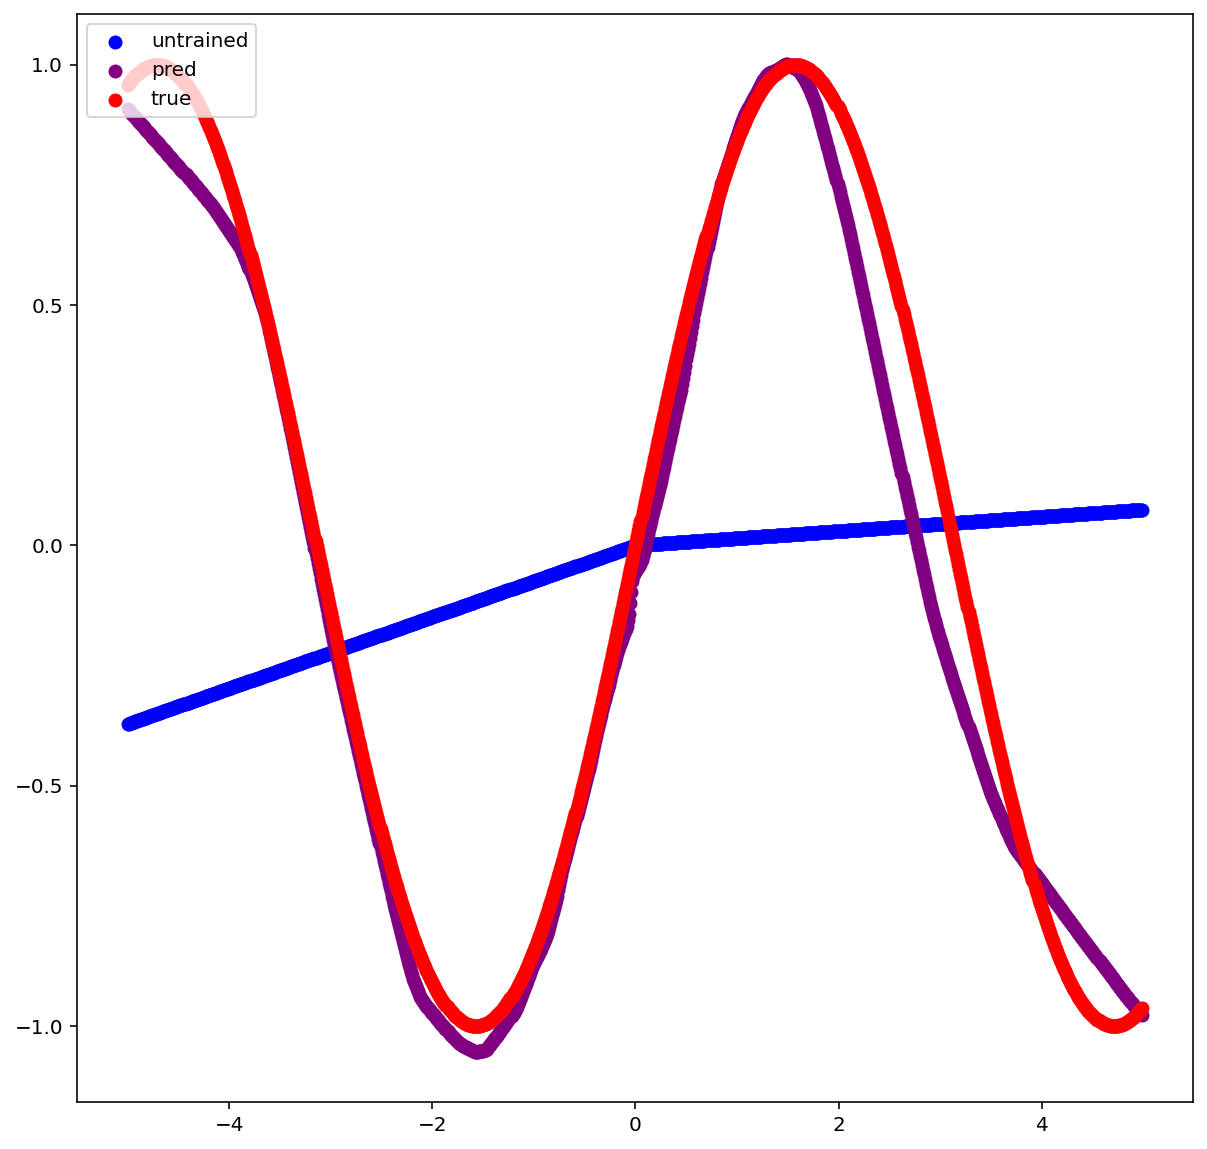

In [ ]:
import matplotlib.pyplot as plt

xs = test_ds[:, 0]
ys = test_ds[:, 1]
untrained = pred_step(train_state, xs)
preds = pred_step(trained_state, xs)

plt.figure(figsize=(10, 10))
plt.scatter(xs, untrained, c='blue', label="untrained")
plt.scatter(xs, preds, c='purple', label="pred")
plt.scatter(xs, ys, c='red', label="true")
plt.legend(loc='upper left')

## More resources

For more advanced Jaxloop topics, see our [Intermediate Colab](https://colab.corp.google.com/google_src/files/head/depot/google3/third_party/py/jaxloop/notebooks/Jaxloop_Intermediate.ipynb), [Actions](http://go/jaxloop-actions) information, and [API Overview](http://go/jaxloop-api).